In [3]:
# Importing required libraries
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import time

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Metrices
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

In [2]:
os.getcwd()

'C:\\Users\\nikhi\\606 Capstone'

In [3]:
os.chdir("C:/UMBC/606 Capstone/Data")

In [4]:
# !pip install py7zr

In [4]:
!python -m py7zr x train.7z

## Data Preperation

I have used this <a href="https://github.com/skshashankkumar41/Microsoft-Malware-Detection/blob/master/Microsoft_Malware_Detection.ipynb">**github**</a> repo as reference. 

### 1. Separating .byte files from .asm files


In [5]:
root = "C:/UMBC/606 Capstone/Data/train/"
files = os.listdir(root)

# Creating saperate folders for .asm and .byte files
# Reference: https://www.geeksforgeeks.org/python-check-if-a-file-or-directory-exists-2/

if not os.path.isdir(root+"byte_files"):
    os.makedirs(root+"byte_files")

if not os.path.isdir(root+"asm_files"):
    os.makedirs(root+"asm_files")

In [6]:
# Moving files to their respective folders
from tqdm import tqdm

for file in tqdm(files):
    if file.endswith("asm"):
        shutil.move(root+file, root+"asm_files")
    if file.endswith("bytes"):
        shutil.move(root+file, root+"byte_files")
        
asm_files = os.listdir(root+"/asm_files")
byte_files = os.listdir(root+"/byte_files")

print("Number of asm files: ", len(asm_files))
print("Number of byte files: ", len(byte_files))

100%|██████████████████████████████████████████████████████████████████████████| 21736/21736 [00:18<00:00, 1144.98it/s]

Number of asm files:  10868
Number of byte files:  10868


In [16]:
# Calculating the sizes of asm files
root_bytes = "D:/Nikhil/Data 606/byte_files/"
root_asm = "D:/Nikhil/Data 606/asm_files/"

asm_files = os.listdir(root_asm)
byte_files = os.listdir(root_bytes)

byte_file_sizes = []
asm_file_sizes = []

for file in tqdm(byte_files):
    byte_file_sizes.append(os.path.getsize(root_bytes+file)/(1024*1024))
    
for file in tqdm(asm_files):
    asm_file_sizes.append(os.path.getsize(root_asm+file)/(1024*1024))
    
print("Total size of the bytes file: ", sum(byte_file_sizes)/1024, "GB")
print("Total size of the asm files: ", sum(asm_file_sizes)/1024, "GB")

100%|██████████████████████████████████████████████████████████████████████████| 10868/10868 [00:04<00:00, 2319.77it/s]

Total size of the bytes file:  47.355384214781225 GB
Total size of the asm files:  136.97536832094193 GB


In [4]:
# Loading the labels
labels = pd.read_csv("C:/UMBC/606 Capstone/Data/trainLabels.csv")
print(labels.shape)
labels.head()

(10868, 2)


Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1
2  05EeG39MTRrI6VY21DPd      1
3  05rJTUWYAKNegBk2wE8X      1
4  0AnoOZDNbPXIr2MRBSCJ      1

In [18]:
# Sanity check, if both asm and byte filenames are in same order
filenames_byte = [file.split(".")[0] for file in byte_files]
filenames_asm = [file.split(".")[0] for file in asm_files]

is_true = []

for i in range(len(asm_files)):
    is_true.append(filenames_asm[i] == filenames_byte[i])
    
sum(is_true)

10868

In [19]:
# Creating a dataset of file sizes
data_dict = {"Id": filenames_byte,
            "byte_file_size": byte_file_sizes,
            "asm_file_size": asm_file_sizes}

data_df = pd.DataFrame(data_dict, columns=["Id", "byte_file_size", "asm_file_size"])


data_df.head()

Id  byte_file_size  asm_file_size
0  01azqd4InC7m9JpocGv5        5.012695      56.229886
1  01IsoiSMh5gxyDYTl4CB        6.556152      13.999378
2  01jsnpXSAlgw6aPeDxrU        4.602051       8.507785
3  01kcPWA9K2BOxQeS5Rju        0.679688       0.078190
4  01SuzwMJEIXsK7A8dQbl        0.438965       0.996723

In [20]:
# Writing the dataset to the disk
data_df.to_csv("C:/UMBC/606 Capstone/Data/file_size.csv", index=False)
dx = pd.read_csv("C:/UMBC/606 Capstone/Data/file_size.csv")
dx.head(2)

Id  byte_file_size  asm_file_size
0  01azqd4InC7m9JpocGv5        5.012695      56.229886
1  01IsoiSMh5gxyDYTl4CB        6.556152      13.999378

In [41]:
# Merging class labels with data
data = pd.concat([data_df.set_index("Id"), labels.set_index("Id")], axis=1, join='inner')
data.head()

byte_file_size  asm_file_size  Class
Id                                                        
01azqd4InC7m9JpocGv5        5.012695      56.229886      9
01IsoiSMh5gxyDYTl4CB        6.556152      13.999378      2
01jsnpXSAlgw6aPeDxrU        4.602051       8.507785      9
01kcPWA9K2BOxQeS5Rju        0.679688       0.078190      1
01SuzwMJEIXsK7A8dQbl        0.438965       0.996723      8

In [6]:
x = labels.Class.unique()
y = np.array(labels.groupby('Class').count())
y = y.reshape(-1)

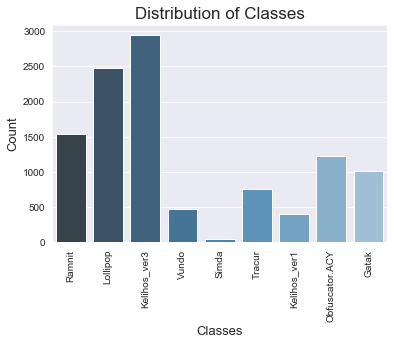

In [11]:
#Distribution of classes
levels = ["Ramnit","Lollipop", "Kelihos_ver3", "Vundo", "Simda","Tracur","Kelihos_ver1","Obfuscator.ACY","Gatak"]
label_text = pd.DataFrame(levels, columns=["Label_text"])

sns.set_style(style="darkgrid")
ax = sns.barplot(x, y, palette="Blues_d")
ax.set_xticklabels(label_text['Label_text'], rotation='vertical', fontsize=10)
plt.title("Distribution of Classes", fontsize=17)
plt.xlabel("Classes", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

**Observation:** The dataset is imbalanced

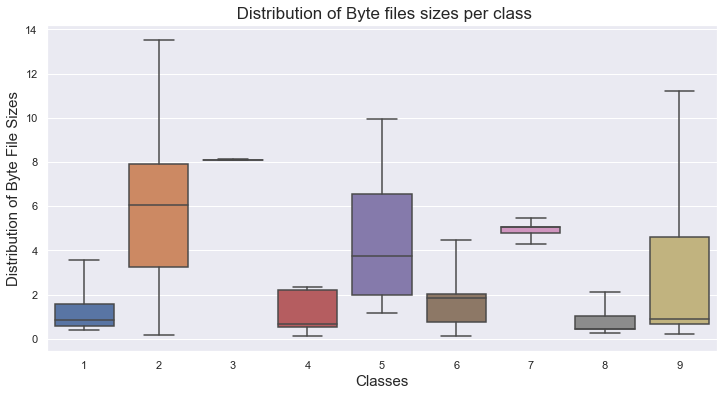

In [95]:
# Plotting Distribution of Byte files sizes per class 
plt.figure(figsize=(12,6))
sns.boxplot(x="Class", y="byte_file_size", data=data, whis=2.0, showfliers = False)
plt.xlabel("Classes", fontsize = 15)
plt.ylabel("Distribution of Byte File Sizes", fontsize = 15)
plt.title(" Distribution of Byte files sizes per class", fontsize = 17)
plt.show()

**Observation:**

* The distribution of the byte file sizes for each class is not the same.

* The byte file sizes of class 2 range from around 0.3 MB to approximately 13 MB.

* The size of all the byte files in class 3 is just above 8 MB.

* The byte file sizes of class 7 are between 4 MB to 6 MB.

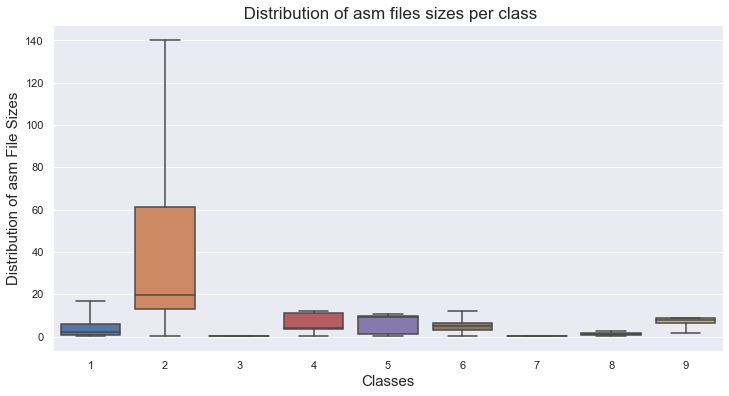

In [98]:
# Plotting Distribution of Asm files sizes per class 
plt.figure(figsize=(12,6))
sns.boxplot(x="Class", y="asm_file_size", data=data, whis=2.0, showfliers = False)
plt.xlabel("Classes", fontsize = 15)
plt.ylabel("Distribution of asm File Sizes", fontsize = 15)
plt.title(" Distribution of asm files sizes per class", fontsize = 17)
plt.show()

**Observation :**

* The distribution of the size of the asm files is different for each class.

* The size of asm files is large compared to that of byte files.

## Feature Engineering

#### I have unigrams.csv from the byte files using Extracting Unigrams from byte files.ipynb

In [21]:
# loading the unigram dataset
unigrams = pd.read_csv("C:/UMBC/606 Capstone/Data/train/unigram.csv", index_col=False)
unigrams.head()

ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5.txt  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB.txt   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU.txt   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju.txt   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl.txt   19764   710   302   433   559   410   262   249   

      8  ...    f7    f8    f9    fa    fb    fc    fd     fe     ff     ??  
0  2965  ...  2804  3687  3101  3211  3097  2758  3099   2759   5753   1824  
1  9291  ...   451  6536   439   281   302  7639   518  17001  54902   8588  
2  9107  ...  2325  2358  2242  2885  2863  2471  2786   2680  49144    468  
3  1078  ...   478   873   485   462   516  1133   471    761   7998  13940  
4   422  ...   847   947   350   209   239   653   221    242   2199   9008  

[5 rows x 258 columns]

In [22]:
# Checking the shape of unigrams dataframe
unigrams.shape

(10868, 258)

In [23]:
# Removing the .txt from the ID column
unigrams['ID']  = unigrams['ID'].str.split('.').str[0]
unigrams.head()

ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl   19764   710   302   433   559   410   262   249   

      8  ...    f7    f8    f9    fa    fb    fc    fd     fe     ff     ??  
0  2965  ...  2804  3687  3101  3211  3097  2758  3099   2759   5753   1824  
1  9291  ...   451  6536   439   281   302  7639   518  17001  54902   8588  
2  9107  ...  2325  2358  2242  2885  2863  2471  2786   2680  49144    468  
3  1078  ...   478   873   485   462   516  1133   471    761   7998  13940  
4   422  ...   847   947   350   209   239   653   221    242   2199   9008  

[5 rows x 258 columns]

In [24]:
# Loading the labels
labels = pd.read_csv("C:/UMBC/606 Capstone/Data/trainLabels.csv")
print(labels.shape)
labels.head(2)

(10868, 2)


Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1

In [25]:
# Merging unigrams dataframe with class labels with data
unigrams_df = pd.concat([unigrams.set_index("ID"), labels.set_index("Id")], axis=1, join='inner')
print(unigrams_df.shape)
unigrams_df.head(2)

(10868, 258)


0     1     2     3     4     5     6     7     8  \
01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201  2965   
01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589  9291   

                         9  ...    f8    f9    fa    fb    fc    fd     fe  \
01azqd4InC7m9JpocGv5  3205  ...  3687  3101  3211  3097  2758  3099   2759   
01IsoiSMh5gxyDYTl4CB   358  ...  6536   439   281   302  7639   518  17001   

                         ff    ??  Class  
01azqd4InC7m9JpocGv5   5753  1824      9  
01IsoiSMh5gxyDYTl4CB  54902  8588      2  

[2 rows x 258 columns]

In [26]:
del unigrams

## Multivariate Analysis

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(unigrams_df.drop(['Class'], axis=1))

In [9]:
# Reducing the dimensionality of the Data Using T-SNE
import time

tsne=TSNE(perplexity=30, n_jobs=4)

start = time.time()
tsne_data = tsne.fit_transform(unigrams_df.drop(['Class'], axis=1))
end = time.time()

tsne_time = end-start

In [11]:
# Using T-SNE to plot the 258 dimensional data on a 2-dimensional plane
vis_x = tsne_data[:, 0]
vis_y = tsne_data[:, 1]

In [12]:
# Using plotly to plot interactive scatter plot
import plotly.express as px

fig = px.scatter(x=vis_x, y=vis_y, color=unigrams_df['Class'],
                title="T-SNE Results (Malware Data)")
fig.show()

**Observation:** 
* I have reduced the 257-dimensional data to 2-dimensional data using T-SNE. Below is the scatter plot of the 2-Dimensional data. 
* Each color represents a different class.  
* We can see that similar colored points are clustered together with some overlap in the center of the image.
* There is a high chance that these data points are well separated in the 257-dimensional space.

**Short Note on T-SNE:**
T-SNE mainly preserves the local structure of the data while converting high dimensional data to low dimensional data. It also suffers from crowding problem. This might be the reason that we see some overlap in the center of the image. 

### Fitting my 1st model

In [8]:
# Train Test Split
# Using stratifies sampling since the distribution is imbalanced
X_train, X_test, y_train, y_test = train_test_split(scaled_data, unigrams_df['Class'], test_size=0.20, random_state=42,
                                                   stratify=unigrams_df['Class'])

print("Shape of X Train: ", X_train.shape)
print("Shape of y Train: ", y_train.shape)
print("-"*75)
print("Shape of X Test: ", X_test.shape)
print("Shape of y Test: ", y_test.shape)

Shape of X Train:  (8694, 257)
Shape of y Train:  (8694,)
---------------------------------------------------------------------------
Shape of X Test:  (2174, 257)
Shape of y Test:  (2174,)


In [17]:
# Fitting a Baseline Model.
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=4)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [21]:
y_pred = rf_classifier.predict(X_test)
y_pred_train = rf_classifier.predict(X_train)

In [19]:
from sklearn.metrics import accuracy_score

In [23]:
print("Accuracy on Test Data",accuracy_score(y_test, y_pred))
print("Accuracy on Training Data",accuracy_score(y_train, y_pred_train))

Accuracy on Test Data 0.9779208831646734
Accuracy on Training Data 0.9898780768345986


In [25]:
from sklearn.metrics import confusion_matrix

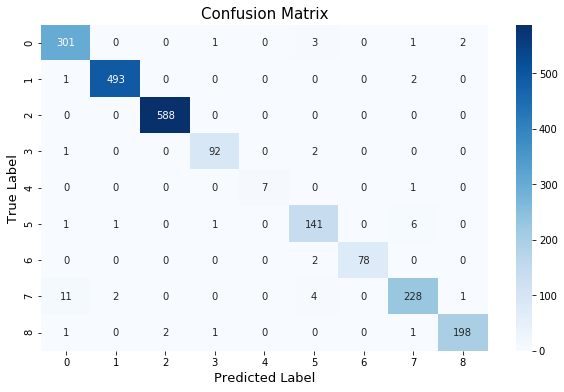

In [44]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

### Finding best Hyperparameters

In [11]:
# Finding the best Hyperparameters
xgb=XGBClassifier()

prams={
     'n_estimators':[500,800,1000],
     'max_depth':[3,5,7]
}

random_cfl=RandomizedSearchCV(xgb,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 51.8min remaining: 14.8min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 60.9min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 67.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 67.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                    

In [12]:
# Displaying best hyperparameters
random_cfl.best_params_

{'n_estimators': 800, 'max_depth': 3}

Accuracy on Training Data 1.0
Accuracy on Test Data 0.9862005519779209
---------------------------------------------------------------------------


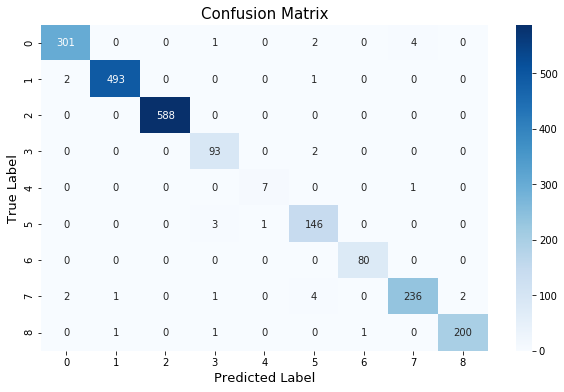

In [14]:
# Training my model with best Hyperparameters and testing it on test data
xgb_classifier = XGBClassifier(n_estimators = 800, max_depth = 3, n_jobs = 4)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
y_pred_train = xgb_classifier.predict(X_train)

print("Accuracy on Training Data",accuracy_score(y_train, y_pred_train))
print("Accuracy on Test Data",accuracy_score(y_test, y_pred))
print("-"*75)

cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

## Adding the file size and image features

In [28]:
# Loading the file size data
file_sizes = pd.read_csv("C:/UMBC/606 Capstone/Data/file_size.csv")
file_sizes.head(2)

Id  byte_file_size  asm_file_size
0  01azqd4InC7m9JpocGv5        5.012695      56.229886
1  01IsoiSMh5gxyDYTl4CB        6.556152      13.999378

In [29]:
# Merging unigrams dataframe with class labels with data
data = pd.concat([unigrams_df, file_sizes.set_index("Id")], axis=1, join='inner')
print(data.shape)
data.head(2)

(10868, 260)


0     1     2     3     4     5     6     7     8  \
01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201  2965   
01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589  9291   

                         9  ...    fa    fb    fc    fd     fe     ff    ??  \
01azqd4InC7m9JpocGv5  3205  ...  3211  3097  2758  3099   2759   5753  1824   
01IsoiSMh5gxyDYTl4CB   358  ...   281   302  7639   518  17001  54902  8588   

                      Class  byte_file_size  asm_file_size  
01azqd4InC7m9JpocGv5      9        5.012695      56.229886  
01IsoiSMh5gxyDYTl4CB      2        6.556152      13.999378  

[2 rows x 260 columns]

In [34]:
# Reference: https://www.hackerearth.com/practice/notes/extracting-pixel-values-of-an-image-in-python/
# function to extract first 800 pixels from image

from PIL import Image

def image_to_csv(root_dir, dest_dir):
    
    images = os.listdir(root_dir)
    
    image_ids = []
    pixels = []
    
    for image in tqdm(images):
        
        if(image.endswith('.png')):
            image_ids.append(image)
            im = Image.open(root_dir+'/'+image)
            pix_val = list(im.getdata())[:800]
            pixels.append(pix_val)
        
    pixels = np.array(pixels)     
    pixels = pd.DataFrame(pixels)
    pixels['ID'] = image_ids
    
    pixels.to_csv(dest_dir+"Image_features.csv", index=False)

In [36]:
image_to_csv(root_dir="C:/UMBC/606 Capstone/Data/train/byte_images/", dest_dir="C:/UMBC/606 Capstone/Data/train/")

100%|████████████████████████████████████████████████████████████████████████████| 10868/10868 [27:00<00:00,  6.71it/s]


In [38]:
# Dictionary of labels
label_endoded = {0:"Ramnit", 1:"Lollipop", 2:"Kelihos_ver3", 3:"Vundo", 4:"Simda", 5:"Tracur", 
                 6:"Kelihos_ver1", 7:"Obfuscator.ACY", 8:"Gatak"}

In [39]:
# loading the image features dataframe
image_features = pd.read_csv("C:/UMBC/606 Capstone/Data/train/Image_features.csv")
print(image_features.shape)
image_features.head(2)

(10868, 801)


0   1   2   3   4   5   6   7   8   9  ...  791  792  793  794  795  796  \
0  48  48  52  48  49  48  48  48  32  69  ...   48   32   48   48   32   55   
1  48  48  52  48  49  48  48  48  32  67  ...   48   32   48   68   32   67   

   797  798  799                        ID  
0   68   32   49  01azqd4InC7m9JpocGv5.png  
1   55   32   48  01IsoiSMh5gxyDYTl4CB.png  

[2 rows x 801 columns]

In [40]:
# Removing the .png from the ID column
image_features['ID']  = image_features['ID'].str.split('.').str[0]
image_features.head(2)

0   1   2   3   4   5   6   7   8   9  ...  791  792  793  794  795  796  \
0  48  48  52  48  49  48  48  48  32  69  ...   48   32   48   48   32   55   
1  48  48  52  48  49  48  48  48  32  67  ...   48   32   48   68   32   67   

   797  798  799                    ID  
0   68   32   49  01azqd4InC7m9JpocGv5  
1   55   32   48  01IsoiSMh5gxyDYTl4CB  

[2 rows x 801 columns]

In [42]:
# Merging image_features dataframe with class labels with data
data = pd.concat([data, image_features.set_index("ID")], axis=1, join='inner')
print(data.shape)
data.head(2)

(10868, 1060)


0     1     2     3     4     5     6     7     8  \
01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201  2965   
01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589  9291   

                         9  ...  790  791  792  793  794  795  796  797  798  \
01azqd4InC7m9JpocGv5  3205  ...   48   48   32   48   48   32   55   68   32   
01IsoiSMh5gxyDYTl4CB   358  ...   68   48   32   48   68   32   67   55   32   

                      799  
01azqd4InC7m9JpocGv5   49  
01IsoiSMh5gxyDYTl4CB   48  

[2 rows x 1060 columns]

In [49]:
# Saving the final dataset
data.to_csv("C:/UMBC/606 Capstone/Data/train/final_dataset.csv", index=False)

#### Multivariate Analysis on new dataset

In [50]:
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(['Class'], axis=1))

# Reducing the dimensionality of the Data Using T-SNE
import time

tsne=TSNE(perplexity=30, n_jobs=4)

start = time.time()
tsne_data = tsne.fit_transform(scaled_data)
end = time.time()

tsne_time = end-start

print("Time taken by the T-SNE algorithm: ", tsne_time, "seconds")

# Using T-SNE to plot the 258 dimensional data on a 2-dimensional plane
vis_x = tsne_data[:, 0]
vis_y = tsne_data[:, 1]

fig = px.scatter(x=vis_x, y=vis_y, color=data['Class'],
                title="T-SNE Results (Malware Data)")
fig.show()

Time taken by the T-SNE algorithm:  184.75447750091553 seconds


In [2]:
# Saving the final dataset
data = pd.read_csv("C:/UMBC/606 Capstone/Data/train/final_dataset.csv")

In [3]:
# Train Test Split
# Using stratifies sampling since the distribution is imbalanced
X_train, X_test, y_train, y_test = train_test_split(data.drop("Class", axis=1), data['Class'], test_size=0.20, random_state=42,
                                                   stratify=data['Class'])

print("Shape of X Train: ", X_train.shape)
print("Shape of y Train: ", y_train.shape)
print("-"*75)
print("Shape of X Test: ", X_test.shape)
print("Shape of y Test: ", y_test.shape)

Shape of X Train:  (8694, 1059)
Shape of y Train:  (8694,)
---------------------------------------------------------------------------
Shape of X Test:  (2174, 1059)
Shape of y Test:  (2174,)


### Training the XG Boost Model 

In [5]:
# Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Modeling
xgb_classifier = XGBClassifier(n_estimators = 800, max_depth = 3, n_jobs = 4)
xgb_classifier.fit(X_train_scaled, y_train)

y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_train = xgb_classifier.predict(X_train_scaled)

print("Accuracy on Training Data: ",accuracy_score(y_train, y_pred_train))
print("Accuracy on Test Data: ",accuracy_score(y_test, y_pred))
print("-"*75)

Accuracy on Training Data:  1.0
Accuracy on Test Data:  0.9921803127874885
---------------------------------------------------------------------------


In [13]:
# Printing Classification Report
levels = ["Ramnit","Lollipop", "Kelihos_ver3", "Vundo", "Simda","Tracur","Kelihos_ver1","Obfuscator.ACY","Gatak"]
print(classification_report(y_test,y_pred,target_names=levels))

                precision    recall  f1-score   support

        Ramnit       0.99      0.99      0.99       308
      Lollipop       0.99      0.99      0.99       496
  Kelihos_ver3       1.00      1.00      1.00       588
         Vundo       0.99      1.00      0.99        95
         Simda       0.88      0.88      0.88         8
        Tracur       0.99      0.98      0.98       150
  Kelihos_ver1       0.99      1.00      0.99        80
Obfuscator.ACY       0.99      0.98      0.98       246
         Gatak       0.99      0.99      0.99       203

      accuracy                           0.99      2174
     macro avg       0.98      0.98      0.98      2174
  weighted avg       0.99      0.99      0.99      2174



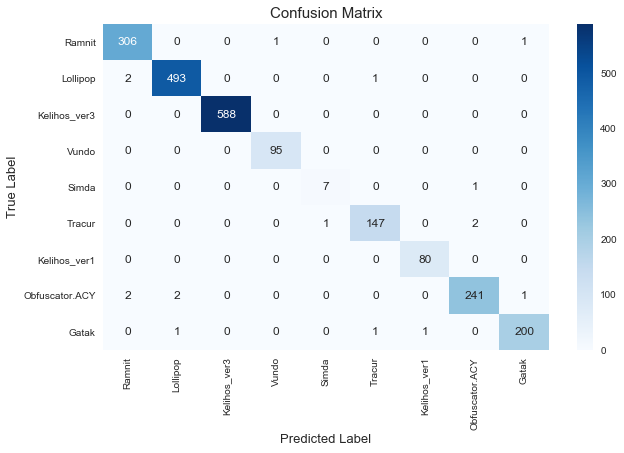

In [25]:
# Displaying the confusion matrix with actual number of instances
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d',
           xticklabels=levels, yticklabels=levels)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

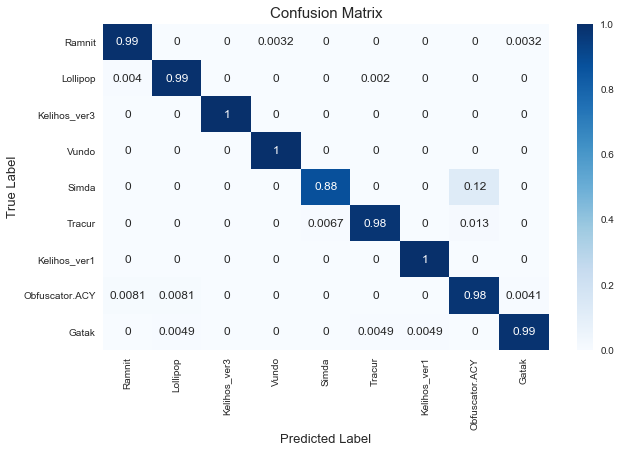

In [24]:
# Displaying normailized Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', #fmt='d',
           xticklabels=levels, yticklabels=levels)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix", fontsize=15)
plt.show()